## Homework 10: The Adventure of the Moonlighting Genes
##### By Kevin Liu

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(112)

### 1. Write a Function That Simulates Positive Control Data

First, we will use a generative model assumed by NMF to define a function that generates synthetic data for N genes and M experiments, generated from R underlying gene batteries.

In [2]:
def simulate(N, M, R, n, C_min = 90000, C_max = 110000):
    """input
            N: number of genes
            M: number of experiments
            R: number of gene batteries
            n: number of moonlighting genes
            C_min: minimum number of counts
            C_max: maximum number of counts
        output
            V_obs: observed counts matrix (NxM)
            V_exp: expected counts matrix (NxM)
            W: current weights matrix (NxR)
            H: current mixture coefficients matrix (RxM)
    """
    # Print randomly selected number of moonlighting genes
    print("Number of moonlighting genes: " + str(n))
    
    # Initialize W
    W = np.zeros((N, R))
    for i in range(N):
        k = np.random.choice(R)
        W[i, k] = 1
        if i in [np.random.choice(N) for i in range(n)]:
            if k-1 in range(R):
                W[i, k-1] = 1 
            else: 
                W[i, k+1] = 1
                
    # Perform row normalization
    col_sum = np.sum(W, axis = 0)
    for i in range(N):
        W[i, :] = W[i, :]/col_sum
    
    # Initialize H
    H = np.random.dirichlet(np.ones(R), size = M).T
    
    # Calculate lambda
    C = np.random.choice(range(C_min, C_max), size = M)
    V_exp = C * (W @ H)
    
    # Calculate simulated V
    V_obs = np.random.poisson(V_exp)
    
    return V_obs, V_exp, W, H


def plot_W_heatmap(W, N, R, ylabs):
    """
    Plots heatmap of W with R number of modules (i.e., columns)
    """
    plt.figure(figsize = (5, 20))
    sns.heatmap(W, xticklabels = [int(i) for i in np.linspace(1, R, R)], yticklabels = ylabs, annot = True)
    plt.xlabel('Module')
    plt.ylabel("Gene")
    plt.show()

After some function definitions, we will generate our synthetic data for N = 100 genes and M = 60 experiments, generated from R = 5 underlying gene batteries with a random number of moonlighting genes ranging from 2 to 5.

In [3]:
# N = 100 genes, M = 60 experiments, R = 5 gene batteries
N, M, R, n = 100, 60, 5, np.random.randint(2, 5)

# Simulate data using specified parameters
V_obs, V_exp, W, H = simulate(N, M, R, n)

Number of moonlighting genes: 2


We will now visualize our gene battery assignments to demonstrate that our function generates reasonable data.

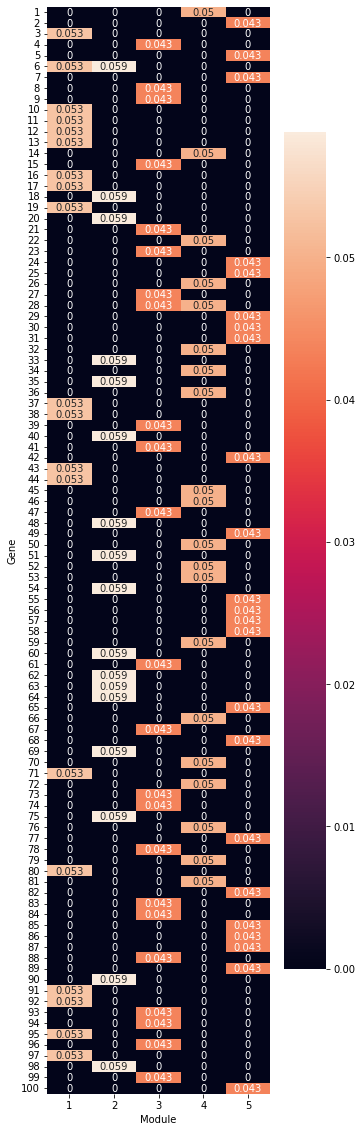

In [4]:
row_names = [int(i) for i in np.linspace(1, N, N)]
plot_W_heatmap(W, N, R, row_names)

Based on the above plot, we can conclude that our simulator function generated reasonable data, where each gene battery containes a number of genes, each gene within a gene battery have the same value, and there are the same number of moonlighting genes as the randomly generated known number of moonlighting genes (namely, genes 6 and 28).

### 2. Implement Nonnegative Matrix Factorization

Here, we will implement NMF following the description in Lee and Seung (1999).

In [5]:
def log_likelihood(V_obs, V_exp):
    """input
            V_obs: observed counts matrix (NxM)
            V_exp: expected counts matrix (NxM)
        output
            ll: total log likelihood of data given model
    """
    #Calculate loglikelihood using observed counts and expected counts
    ll = np.sum(V_obs * np.log(V_exp) - V_exp)
    
    return ll


def calculate_C(V_obs):
    """input
            V_obs: observed counts matrix (NxM)
        output
            C: total number of counts per experiment (Rx1)
    """
    # Calculate C by summing over the columns of V_obs
    C = np.sum(V_obs, axis = 0)
    
    return C


def calculate_lambda(C, W, H):
    """input
            C: total number of counts per experiment (Rx1)
            W: current weights matrix (NxR)
            H: current mixture coefficients matrix (RxM)
        output
            V_exp: expected counts matrix (NxM)
    """
    # Calculate expected counts V_exp from C, W, and H
    V_exp = C[np.newaxis, :] * (W @ H)
    
    return V_exp


def update(V_obs, V_exp, C, W, H):
    """input
            V_obs: observed counts matrix (NxM)
            V_exp: expected counts matrix (NxM)
            C: total number of counts per experiment (Rx1)
            W: current weights matrix (NxR)
            H: current mixture coefficients matrix (RxM)
        output
            W_new: updated weights matrix (NxR)
            H_new: updated mixture coefficients matrix (RxM)
    """
    # Update W
    W_new = W * (V_obs / V_exp @ (C[:, np.newaxis] * (H.T)))
    
    # Renormalize W
    W_new = W_new / np.sum(W_new, axis = 0)
    
    # Update H
    H_new = H * ((V_obs / V_exp).T @ W).T
    
    return W_new, H_new

In [6]:
def NMF(V_obs, R, threshold = 0.01):
    """input
            V_obs: observed counts matrix (NxM)
            R: number of gene batteries
            threshold: convergence threshold
        output
            W: updated weights matrix (NxR)
            H: updated mixture coefficients matrix (RxM)
            ll_list: list of log likelihoods for each iteration
    """
    # Initialize W and H to random guesses
    W = np.random.dirichlet(np.ones(V_obs.shape[0]), size = R).T
    H = np.random.dirichlet(np.ones(R), size = V_obs.shape[1]).T
    
    # Calculate lambda
    C = calculate_C(V_obs)
    V_exp = calculate_lambda(C, W, H)
    
    # Define log likelihood initial values
    ll = float('inf')
    ll_diff = float('inf')
    ll_list = []
    
    # Check for convergence
    while ll_diff > threshold:

        # Update W and H
        W_new, H_new = update(V_obs, V_exp, C, W, H)
        W = W_new
        H = H_new
        
        # Calculate lambda
        V_exp = calculate_lambda(C, W, H)

        # Calculate the log likelihood
        ll_new = log_likelihood(V_obs, V_exp)
        
        # Append log likelihood to a list
        ll_list.append(ll_new)
        
        # Update difference in log likelihoods
        ll_diff = abs(ll_new - ll)
        
        # Update the current log likelihood
        ll = ll_new
    
    return W, H, ll_list

### 3. Test Your Implementation

After implementing our NMF algorithm, we will apply our NMF function to our generated synthetic datasets and vary the parameters of our synthetic data.

In [7]:
def plot_NMF_R(V, R_min = 3, R_max = 6):
    """
    Run NMF on supplied counts matrix and generate plots to determine the most likely value of R
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    convergence = []
    for R in range(R_min, R_max+1):
        W, H, ll_list = NMF(V, R)
        ax1.plot(ll_list, label = f"R = {R}")
        convergence.append(ll_list[-1])
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Log Likelihood")
    ax1.legend()

    ax2.plot(range(R_min, R_max+1), convergence, marker = "o")
    ax2.set_xlabel("R")

    plt.tight_layout(pad = 0.5)
    plt.show()

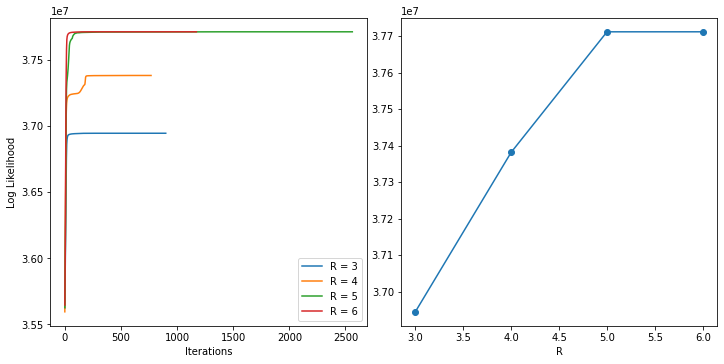

In [8]:
# Run NMF and determine most likely R in range between 3 to 6
plot_NMF_R(V_obs)

Based on the above plots, we can conclude that our NMF algorithm reconstructs the known gene batteries in our synthetic data reasonably well. Specifically, we constructed our synthetic data with R = 5 gene batteries, which is evident from the right pannel of our plot as the log-likelihood begins to plateau at R = 5, suggesting that there is most likely R = 5 gene batteries; this is further supported by the left pannel of our plot of log-likelihood against the number of iterations, where the number of iterations for R = 5 and R = 6 achieve much larger log-likelihoods compared to R = 3 and R = 4.

### 4. Analyze the Adler Data

Finally, we will apply our NMF analysis to the Adler dataset. We will first read in the Adler dataset and attempt to determine the number of gene batteries using the same approach as demonstrated above.

In [9]:
# Read in the Adler dataset
V, genes = [], []

with open("w10-data.tbl") as f:
    for n, line in enumerate(f):
        fields = line.split()
        genes.append(fields[0])
        V.append([int(i) for i in fields[1:]])

V = np.asarray(V)

# Check the dimensions of V
V.shape

(100, 60)

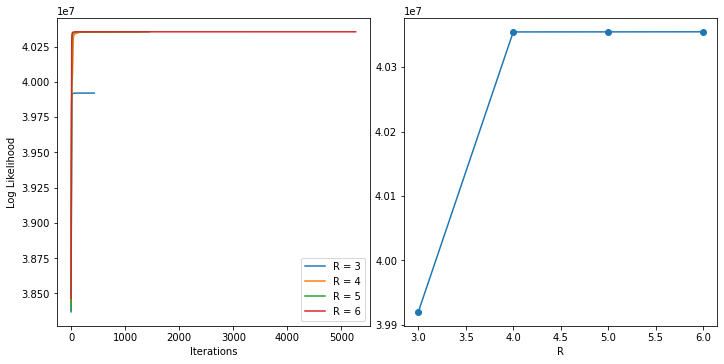

In [10]:
# Run NMF and determine most likely R in range between 3 to 6
plot_NMF_R(V)

Here, we see that the most likely number of gene batteries is R = 4, as illustrated in the above plot. Specifically, we see that R = 4, R = 5, and R = 6 yields much higher log-likelihoods compared to R = 3 in the left pannel of our plot; furthermore, we see that the log-likelihood begins to plateau at R = 4, suggesting that the most likely number of gene batteries in the Adler dataset is R = 4 when considering a range of R between 3 to 6.

Next, we will assume that R = 4 based on our best guess, run our NMF function, and visualize our data to determine the number and identity of the genes in each battery and the number and identity of moonlighting genes in the Adler dataset.

In [11]:
# Use best guess of R = 4
R = 4

# Run NMF
W, H, ll_list = NMF(V, R)

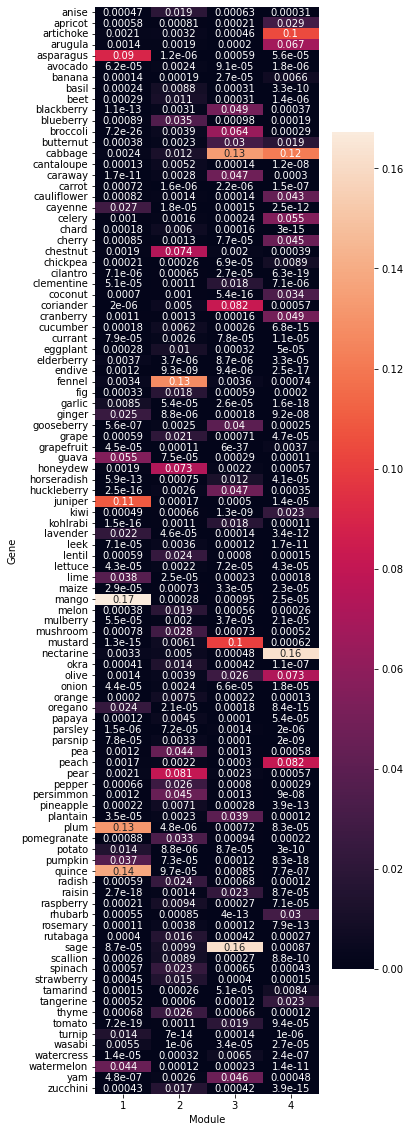

In [12]:
plot_W_heatmap(W, len(genes), R, genes)

To better elucidate the number and identity of genes in each gene battery and the number and identity of moonlighting genes, we will normalize the matrix by row, identify and apply a reasonable threshold to dichotomize the genes as either present or not present, and re-visualize our results.

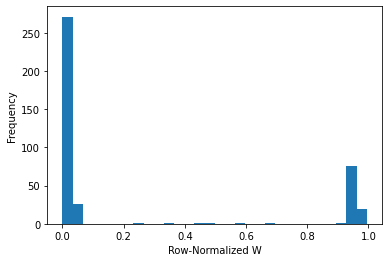

In [13]:
# Normalize W through the rows
W = W / W.sum(axis = 1, keepdims = True)

# Plot the distribution of W
plt.hist(W.flatten(), bins = 30)
plt.xlabel('Row-Normalized W')
plt.ylabel('Frequency')
plt.show()

Based on the above histogram, we see that the majority of W values are near 0 and a small fraction near 1 while there are several W values with very low frequencies between 0.2 and 0.7 that are possible moonlighting genes. With this knowledge, we will assume a threshold of 0.2 to dichotomize our genes as either present or not present for a gene battery.

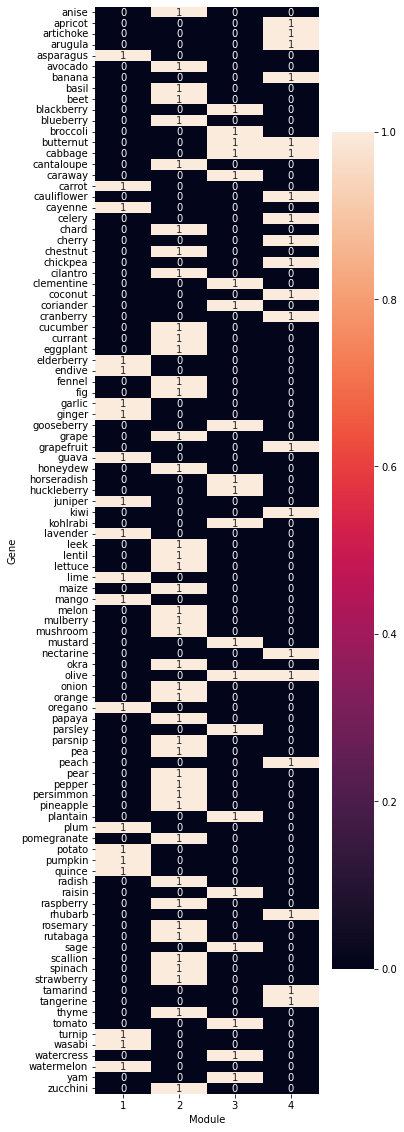

In [14]:
# Convert W to binary using a threshold of 0.2
W_binary = np.where(W > 0.2, 1, 0)

# Plot W
plot_W_heatmap(W_binary, len(genes), R, genes)

Based on the above heatmap, we can easily see that the genes ```butternut```, ```cabbage```, and ```olive``` are moonlighting genes with our best guess of R = 4. For the number and identity of genes in each gene battery, as well as the number and identity of moonlighting genes, please refer to the computed results printed below.

In [15]:
# Print genes in each battery
for battery in range(R):
    n_gene = np.sum(W_binary, axis = 0)[battery]
    battery_gene = []
    for i in range(W.shape[0]):
        if W_binary[i, battery] == 1:
            battery_gene.append(genes[i])
    print("There are {} genes in gene battery {}:\n{}\n".format(n_gene, battery+1, ", ".join(battery_gene)))

There are 20 genes in gene battery 1:
asparagus, carrot, cayenne, elderberry, endive, garlic, ginger, guava, juniper, lavender, lime, mango, oregano, plum, potato, pumpkin, quince, turnip, wasabi, watermelon

There are 43 genes in gene battery 2:
anise, avocado, basil, beet, blueberry, cantaloupe, chard, chestnut, cilantro, cucumber, currant, eggplant, fennel, fig, grape, honeydew, leek, lentil, lettuce, maize, melon, mulberry, mushroom, okra, onion, orange, papaya, parsnip, pea, pear, pepper, persimmon, pineapple, pomegranate, radish, raspberry, rosemary, rutabaga, scallion, spinach, strawberry, thyme, zucchini

There are 20 genes in gene battery 3:
blackberry, broccoli, butternut, cabbage, caraway, clementine, coriander, gooseberry, horseradish, huckleberry, kohlrabi, mustard, olive, parsley, plantain, raisin, sage, tomato, watercress, yam

There are 20 genes in gene battery 4:
apricot, artichoke, arugula, banana, butternut, cabbage, cauliflower, celery, cherry, chickpea, coconut, cr

In [16]:
# Print moonlighting genes
moonlighting_gene = []
for i, gene in enumerate(genes):
    if np.sum(W_binary, axis = 1)[i] > 1:
        moonlighting_gene.append(gene)
print("There are {} moonlighting genes: {}".format(len(moonlighting_gene), ", ".join(moonlighting_gene)))

There are 3 moonlighting genes: butternut, cabbage, olive
